In [2]:
import tensorflow as tf
import glob
#import tensorflow_io as tfio
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from scipy import signal
import matplotlib
#matplotlib.use('Agg')

In [3]:
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
config.log_device_placement = True

sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: GeForce GTX 1650 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5



In [4]:
tf.__version__

'2.3.0'

In [5]:
tf.test.is_gpu_available()


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [6]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    print("Name:", gpu.name, "  Type:", gpu.device_type)

Name: /physical_device:GPU:0   Type: GPU


(150, 230)


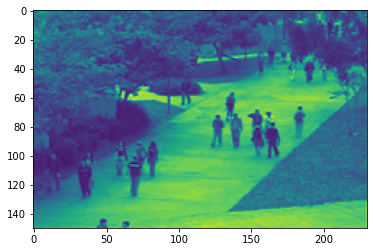

In [7]:
im = Image.open('UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/Train001/002.tif')
im = im.resize((230,150))
print(np.array(im).shape)
plt.imshow(im)

In [8]:
# n = 10

# a = np.zeros((int(len(files)/n), n, 227, 227))
# i = 0
# idx = 0

# for filename in range(0, len(files)):
#     im = Image.open(files[filename])
#     im = im.resize((227,227))
#     a[idx,i,:,:] = np.array(im, dtype=np.float32)/255.0
#     i = i + 1
#     if i > 9:
#         idx = idx + 1
#         i = 0


In [9]:
IMG_HEIGHT=227
IMG_WIDTH=227
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE=16

train_set = 'UCSD_Anomaly_Dataset.v1p2/UCSDped1/Train/*/*.tif'

train_files = sorted(glob.glob(train_set))

n = 10
a = np.zeros((int(len(train_files)/n),IMG_HEIGHT, IMG_WIDTH,n)).astype(np.float32)
i = 0
idx = 0

for filename in range(0, len(train_files)):
    im = Image.open(train_files[filename])
    im = im.resize((IMG_WIDTH, IMG_HEIGHT))
    a[idx,:,:,i] = np.array(im)/255.0
    i = i + 1
    if i > 9:
        idx = idx + 1
        i = 0
        
print(a.shape)

train_dataset  = tf.data.Dataset.from_tensor_slices((a, a)).shuffle(1000, 
                                                                    seed=42, 
                                                                    reshuffle_each_iteration=False).batch(BATCH_SIZE)
print(len(list(train_dataset)))

(680, 227, 227, 10)
43


In [10]:
test_set = 'UCSD_Anomaly_Dataset.v1p2/UCSDped1/Test/Test024/*'

test_files = sorted(glob.glob(test_set))

a = np.zeros((int(len(test_files)/n),IMG_WIDTH, IMG_HEIGHT,n)).astype(np.float32)
i = 0
idx = 0

for filename in range(0, len(test_files)):
    im = Image.open(test_files[filename])
    im = im.resize((IMG_WIDTH,IMG_HEIGHT))
    a[idx,:,:,i] = np.array(im, dtype=np.float32)/255.0
    i = i + 1
    if i > 9:
        idx = idx + 1
        i = 0
        
    
test_dataset = tf.data.Dataset.from_tensor_slices((a, a)).batch(1)
print(len(list(test_dataset)))

20


In [11]:
count = 0
for x,y in train_dataset.take(BATCH_SIZE):
    print(x.shape, y.shape)
    count = count + 1
    if count > 5:
        break

(16, 227, 227, 10) (16, 227, 227, 10)
(16, 227, 227, 10) (16, 227, 227, 10)
(16, 227, 227, 10) (16, 227, 227, 10)
(16, 227, 227, 10) (16, 227, 227, 10)
(16, 227, 227, 10) (16, 227, 227, 10)
(16, 227, 227, 10) (16, 227, 227, 10)


(16, 227, 227, 10)


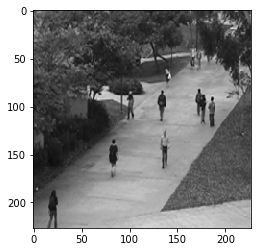

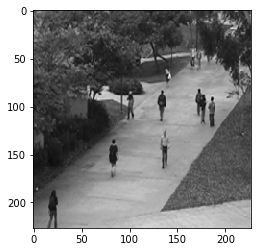

tf.Tensor(
[[0.40392157 0.40392157 0.34509805 ... 0.20784314 0.27058825 0.3137255 ]
 [0.33333334 0.34117648 0.32941177 ... 0.20784314 0.24705882 0.35686275]
 [0.29411766 0.30588236 0.32156864 ... 0.22745098 0.21176471 0.36862746]
 ...
 [0.46666667 0.47058824 0.4745098  ... 0.6745098  0.67058825 0.7529412 ]
 [0.4745098  0.48235294 0.4862745  ... 0.68235296 0.67058825 0.75686276]
 [0.4745098  0.4862745  0.49019608 ... 0.69411767 0.6745098  0.7647059 ]], shape=(227, 227), dtype=float32)


In [12]:
import matplotlib.pyplot as plt

for image,label in train_dataset.take(1):
    print(image.shape)
    img = image[0][:,:,0]
    lbl = label[0][:,:,0]
    plt.imshow(img,cmap=plt.cm.gray, interpolation='nearest')
    plt.show()
    plt.imshow(lbl,cmap=plt.cm.gray, interpolation='nearest')
    plt.show()
    print(img)

In [19]:
#strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

#with strategy.scope():
conv_encoder = tf.keras.Sequential(
            [
                tf.keras.layers.InputLayer(input_shape=(IMG_HEIGHT,IMG_WIDTH,n)),
                tf.keras.layers.Conv2D(512,kernel_size=15, strides=(4,4), activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPool2D(pool_size=2),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(256, kernel_size=4,activation='relu'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.MaxPool2D(pool_size=2),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2D(128, kernel_size=3,activation='relu'),
                tf.keras.layers.BatchNormalization()
            ]
        )

conv_decoder = tf.keras.Sequential(
            [   
                tf.keras.layers.Conv2DTranspose(256, kernel_size=3, activation="relu"),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.UpSampling2D(2, interpolation='nearest'),
                tf.keras.layers.Conv2DTranspose(512, kernel_size=4, activation="relu"),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.UpSampling2D(2, interpolation='nearest'),
                tf.keras.layers.BatchNormalization(),
                tf.keras.layers.Conv2DTranspose(10, kernel_size=15, strides=(4,4),activation="sigmoid")
            ]            
        )


In [20]:
image_input = tf.keras.Input(shape=(IMG_HEIGHT,IMG_WIDTH,10))
encoded = conv_encoder(image_input)
print(encoded.shape)
decoded = conv_decoder(encoded)
print(decoded.shape)

(None, 10, 10, 128)
(None, 227, 227, 10)


In [21]:
conv_ae = tf.keras.Model(inputs=image_input, outputs=decoded)

#conv_ae = tf.keras.Sequential([conv_encoder, conv_decoder])
conv_ae.compile(loss=tf.keras.losses.MeanSquaredError(), 
        optimizer=tf.keras.optimizers.Adam(lr=1e-4, decay=1e-4),
        metrics=['mae'])

In [22]:
#conv_ae(np.ones((1,100,100,1), dkaggletype=np.float32))

conv_ae.summary()




Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 227, 227, 10)]    0         
_________________________________________________________________
sequential (Sequential)      (None, 10, 10, 128)       3551616   
_________________________________________________________________
sequential_1 (Sequential)    (None, 227, 227, 10)      3549962   
Total params: 7,101,578
Trainable params: 7,095,690
Non-trainable params: 5,888
_________________________________________________________________


In [ ]:
history = conv_ae.fit(train_dataset, epochs=30, validation_data=test_dataset)


Epoch 1/30
43/43 [==============================] - 22s 521ms/step - loss: 0.0255 - mae: 0.1244 - val_loss: 0.0785 - val_mae: 0.2453
Epoch 2/30
43/43 [==============================] - 22s 512ms/step - loss: 0.0127 - mae: 0.0757 - val_loss: 0.0417 - val_mae: 0.1680
Epoch 3/30
43/43 [==============================] - 22s 523ms/step - loss: 0.0101 - mae: 0.0656 - val_loss: 0.0304 - val_mae: 0.1444
Epoch 4/30
43/43 [==============================] - 22s 514ms/step - loss: 0.0088 - mae: 0.0601 - val_loss: 0.0276 - val_mae: 0.1340
Epoch 5/30
43/43 [==============================] - 22s 520ms/step - loss: 0.0079 - mae: 0.0560 - val_loss: 0.0274 - val_mae: 0.1313
Epoch 6/30
43/43 [==============================] - 22s 512ms/step - loss: 0.0073 - mae: 0.0534 - val_loss: 0.0228 - val_mae: 0.1187
Epoch 7/30
43/43 [==============================] - 22s 511ms/step - loss: 0.0067 - mae: 0.0507 - val_loss: 0.0173 - val_mae: 0.1006
Epoch 8/30
43/43 [==============================] - 22s 514ms/step - 

In [ ]:
def plot_training_loss(history):

    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    plt.show()

In [ ]:
plot_training_loss(history)

In [ ]:
def plot_image(image):
    print('plot image {}'.format(image.shape))
    plt.imshow(image[:,:,0], cmap=plt.cm.gray, interpolation='nearest')
    plt.axis("off")

In [ ]:
def show_reconstructions(model, images, n_images=5):
    print('show reconstructions = {}'.format(images.shape))
    reconstructions = model.predict(images[:n_images])
    fig = plt.figure(figsize=(n_images * 3, 5))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

In [ ]:
test_images = list(test_dataset.take(1))[0]
test_image = test_images[0]
print(test_image.shape)
show_reconstructions(conv_ae, test_image, n_images=1)

In [ ]:
def plot(img, output, diff, H, threshold, counter):
    #print('inside plot, imgshape {}'.format(img.shape))
    fig, (ax0, ax1, ax2,ax3) = plt.subplots(ncols=4, figsize=(10, 5))
    ax0.set_axis_off()
    ax1.set_axis_off()
    ax2.set_axis_off()
    
    ax0.set_title('input image')
    ax1.set_title('reconstructed image')
    ax2.set_title('diff ')
    ax3.set_title('anomalies')
    
    ax0.imshow(img, cmap=plt.cm.gray, interpolation='nearest') 
    ax1.imshow(output, cmap=plt.cm.gray, interpolation='nearest')   
    ax2.imshow(diff, cmap=plt.cm.viridis, vmin=0, vmax=255, interpolation='nearest')  
    ax3.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
    
    x,y = np.where(H > threshold)
    ax3.scatter(y,x,color='red',s=0.1) 

    plt.axis('off')
    
    fig.savefig('images/{:0>3d}.png'.format(counter))

In [ ]:
threshold = 5.5*255
counter = 0;

for image, _  in test_dataset:
    counter = counter + 1
    output = conv_ae.predict(image)
    output = tf.multiply(output,255.)
    img = tf.multiply(tf.cast(image, tf.float32), 255.)
    diff = tf.subtract(output,img)
    print(diff.shape)
    tmp = diff[0,:,:,0]
    H = signal.convolve2d(tmp, np.ones((4,4)), mode='same')
    plot(img[0,:,:,0], output[0,:,:,0], diff[0,:,:,0], H, threshold, counter)
    

In [ ]:
from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = sorted(glob.glob('images/*.png'))
print(imgs[:10])
for i in imgs:
    new_frame = Image.open(i)
    frames.append(new_frame)
 
# Save into a GIF file that loops forever
frames[0].save('result.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=100, loop=0)